In [1]:
import os
import random

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 10)
%matplotlib inline

In [3]:
import torch
import torch.nn as nn

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

In [5]:
ROOT = ""
SUBMISSIONS_FOLDER = "submissions"
MODEL_CHECHPOINTS_FOLDER = "model_checkpoints"
CATBOOST_DATA_FOLDER = "catboost_data"

data_csv_path = "data.csv"
model_preds_path = "model.csv"
SEED = 42

In [6]:
def create_csv_file(name, predictions, root=SUBMISSIONS_FOLDER):
    df = pd.DataFrame(np.squeeze(predictions))
    
    df.to_csv(os.path.join(root, name), index=False, header=False)
    print("save predictions in: {}".format(os.path.join(root, name)))

In [7]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

In [8]:
df = pd.read_csv(os.path.join(ROOT, data_csv_path), index_col=0)
data_df = df.copy()
data_df

,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,...,Feature_1878,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887
incident,,,,,,,,,,,,,,,,,,,,,
14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,2.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,1,20184
15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,2.0,...,0.143840,0.259385,0.547065,0.287680,0.287680,0,1,1,1,20184
14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,1.0,...,NaN,0.420321,0.242687,NaN,NaN,0,1,0,1,20184
14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,2.0,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20184
14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,3.0,...,NaN,0.045863,NaN,NaN,NaN,0,1,0,1,20184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20559842,NaN,2020-01,1.0,2,34,2.0,2.0,3,0,2.0,...,NaN,0.358156,0.301572,0.187271,NaN,0,0,0,1,20201
20380255,NaN,2020-01,10.0,2,66,2.0,0.0,5,1,3.0,...,0.116099,0.391072,0.391072,0.391072,0.391072,0,0,0,0,20201
20348581,NaN,2020-01,4.0,1,32,1.0,0.0,3,0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20201


In [9]:
model_preds_df = pd.read_csv(os.path.join(ROOT, model_preds_path), index_col=0)
model_preds_df

,PD
incident,
14511110,0.022191
15018800,0.019972
14499737,0.043884
14953427,0.013412
14744453,0.033354
...,...
20559842,NaN
20380255,NaN
20348581,NaN


In [10]:
# вставим предсказания модели в наш датасет поближе к flg_90_12_add для
# возможности видуального сопоставления

data_df.insert(loc=1, column="PD", value=model_preds_df["PD"].values)

In [11]:
data_df["|PD-flg_90_12_add|"] = np.abs(data_df["PD"] - data_df["flg_90_12_add"])
data_df["|PD-flg_90_12_add|"]

incident
14511110    0.022191
15018800    0.019972
14499737    0.043884
14953427    0.013412
14744453    0.033354
              ...   
20559842         NaN
20380255         NaN
20348581         NaN
21118162         NaN
21452003         NaN
Name: |PD-flg_90_12_add|, Length: 82617, dtype: float64

### мельком глянем на типы данных в колонках... насколько оперативка позволит

In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82617 entries, 14511110 to 21452003
Columns: 1911 entries, flg_90_12_add to |PD-flg_90_12_add|
dtypes: float64(1839), int64(71), object(1)
memory usage: 1.2+ GB


In [13]:
# если что type object соответствует колонке "APPLICATION_MONTH"

In [14]:
# в dt.date для сортивроки по дате
datetime_series = pd.to_datetime(data_df["APPLICATION_MONTH"])
data_df["year"] = datetime_series.dt.year
data_df["month"] = datetime_series.dt.month
data_df["APPLICATION_MONTH"] = datetime_series.dt.date

del datetime_series
data_df

,flg_90_12_add,PD,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,|PD-flg_90_12_add|,year,month
incident,,,,,,,,,,,,,,,,,,,,,
14511110,0.0,0.022191,2018-10-01,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,0,0,0,1,20184,0.022191,2018,10
15018800,0.0,0.019972,2018-12-01,1.0,2,49,4.0,0.0,3,1,...,0.287680,0.287680,0,1,1,1,20184,0.019972,2018,12
14499737,0.0,0.043884,2018-10-01,6.0,2,24,1.0,0.0,3,0,...,NaN,NaN,0,1,0,1,20184,0.043884,2018,10
14953427,0.0,0.013412,2018-12-01,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,0,1,1,1,20184,0.013412,2018,12
14744453,0.0,0.033354,2018-11-01,6.0,2,30,4.0,2.0,3,1,...,NaN,NaN,0,1,0,1,20184,0.033354,2018,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20559842,NaN,NaN,2020-01-01,1.0,2,34,2.0,2.0,3,0,...,0.187271,NaN,0,0,0,1,20201,NaN,2020,1
20380255,NaN,NaN,2020-01-01,10.0,2,66,2.0,0.0,5,1,...,0.391072,0.391072,0,0,0,0,20201,NaN,2020,1
20348581,NaN,NaN,2020-01-01,4.0,1,32,1.0,0.0,3,0,...,NaN,NaN,0,1,1,1,20201,NaN,2020,1


In [15]:
# проверим, были ли данные отсортированы по дате

#all(data_df["APPLICATION_MONTH"].sort_values().index == data_df.index)

In [16]:
# проверим, а тестовые данные отсортированы по дате ...

#all(data_df[data_df["flg_90_12_add"].isna()]["APPLICATION_MONTH"].sort_values().index ==\
#    data_df[data_df["flg_90_12_add"].isna()].index)

In [14]:
# проверим, а пересекаются ли по времени train, test данные

print("test date min:", data_df[data_df["flg_90_12_add"].isna()]["APPLICATION_MONTH"].min()) 
print("train date-max:", data_df[~data_df["flg_90_12_add"].isna()]["APPLICATION_MONTH"].max())

test date min: 2020-01-01
train date-max: 2020-03-01


In [16]:
# как мы видим данные действительно пересекаются ... не очень
# приятная новость, но впринципе пересечение лишь на 2 дня, что терпимо ... т.к. разброс по годам - 2года+


In [15]:
data_df["APPLICATION_MONTH"]

incident
14511110    2018-10-01
15018800    2018-12-01
14499737    2018-10-01
14953427    2018-12-01
14744453    2018-11-01
               ...    
20559842    2020-01-01
20380255    2020-01-01
20348581    2020-01-01
21118162    2020-02-01
21452003    2020-03-01
Name: APPLICATION_MONTH, Length: 82617, dtype: object

In [16]:
data_df

,flg_90_12_add,PD,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,|PD-flg_90_12_add|,year,month
incident,,,,,,,,,,,,,,,,,,,,,
14511110,0.0,0.022191,2018-10-01,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,0,0,0,1,20184,0.022191,2018,10
15018800,0.0,0.019972,2018-12-01,1.0,2,49,4.0,0.0,3,1,...,0.287680,0.287680,0,1,1,1,20184,0.019972,2018,12
14499737,0.0,0.043884,2018-10-01,6.0,2,24,1.0,0.0,3,0,...,NaN,NaN,0,1,0,1,20184,0.043884,2018,10
14953427,0.0,0.013412,2018-12-01,4.0,2,26,1.0,0.0,3,1,...,NaN,NaN,0,1,1,1,20184,0.013412,2018,12
14744453,0.0,0.033354,2018-11-01,6.0,2,30,4.0,2.0,3,1,...,NaN,NaN,0,1,0,1,20184,0.033354,2018,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20559842,NaN,NaN,2020-01-01,1.0,2,34,2.0,2.0,3,0,...,0.187271,NaN,0,0,0,1,20201,NaN,2020,1
20380255,NaN,NaN,2020-01-01,10.0,2,66,2.0,0.0,5,1,...,0.391072,0.391072,0,0,0,0,20201,NaN,2020,1
20348581,NaN,NaN,2020-01-01,4.0,1,32,1.0,0.0,3,0,...,NaN,NaN,0,1,1,1,20201,NaN,2020,1


In [ ]:
# не будем сортировать по времени т.к. это нарушает порядок
# следования test данных

In [18]:
# отсортируем все предсказания по времени
#data_df.sort_values(by=["APPLICATION_MONTH"], inplace=True)

In [19]:
#data_df[~data_df["flg_90_12_add"].isna()].sort_values(by=["APPLICATION_MONTH"])

,flg_90_12_add,PD,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,...,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,|PD-flg_90_12_add|,year,month
incident,,,,,,,,,,,,,,,,,,,,,
14511110,0.0,0.022191,2018-10-01,6.0,2,25,2.0,0.0,3,1,...,NaN,NaN,0,0,0,1,20184,0.022191,2018,10
14564041,0.0,0.109525,2018-10-01,3.0,2,44,4.0,0.0,5,1,...,NaN,NaN,0,1,1,0,20184,0.109525,2018,10
14520014,0.0,0.011416,2018-10-01,6.0,2,30,1.0,1.0,3,1,...,NaN,0.263225,0,1,1,1,20184,0.011416,2018,10
14567529,0.0,0.040373,2018-10-01,15.0,2,54,2.0,1.0,5,0,...,NaN,NaN,0,0,1,0,20184,0.040373,2018,10
14486437,0.0,0.016227,2018-10-01,1.0,1,58,2.0,0.0,3,1,...,0.450902,0.450902,0,0,1,1,20184,0.016227,2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21504781,0.0,0.021825,2020-03-01,14.0,2,47,2.0,0.0,3,1,...,NaN,NaN,0,0,0,1,20201,0.021825,2020,3
21437076,0.0,0.008984,2020-03-01,1.0,2,42,2.0,0.0,3,0,...,0.294901,NaN,0,0,0,1,20201,0.008984,2020,3
21432399,0.0,0.012207,2020-03-01,1.0,2,43,3.0,0.0,3,0,...,NaN,NaN,0,1,0,1,20201,0.012207,2020,3


In [17]:
# посмотрим, насколькo много пропусков в тренировочных данных

number_na = df[:len(df)-1000].isna().sum(axis=0) / len(df) * 100
number_na

flg_90_12_add         0.000000
APPLICATION_MONTH     0.000000
Category_Feature_0    0.026629
Category_Feature_1    0.000000
Category_Feature_2    0.000000
                        ...   
Feature_1883          0.000000
Feature_1884          0.000000
Feature_1885          0.000000
Feature_1886          0.000000
Feature_1887          0.000000
Length: 1909, dtype: float64

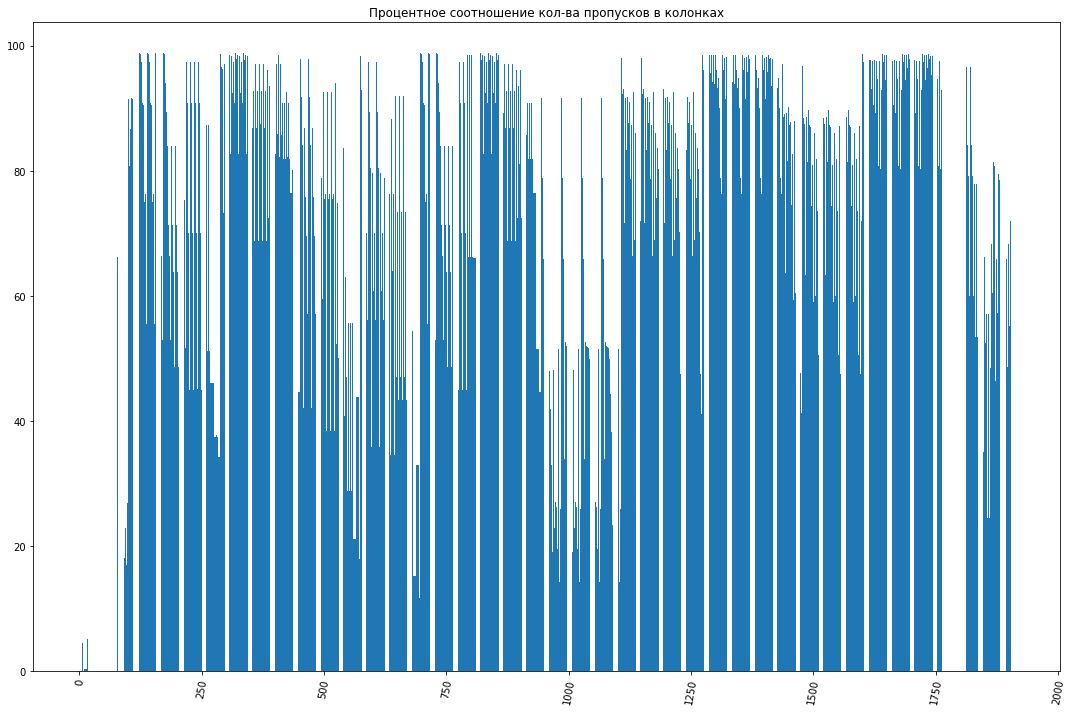

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches((15, 10))

x_labels = number_na.index.values
x_pos = list(range(1, len(x_labels) + 1))

ax.bar(x_pos, height=number_na.values, )
#ax.set_xticks(x_pos)
#ax.set_xticklabels(x_labels)
ax.set_title('Процентное соотношение кол-ва пропусков в колонках')

plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### Запомним индексы строк для train/test

In [19]:
is_nan_index = data_df[data_df["flg_90_12_add"].isna()].index.values
not_nan_index = data_df[~data_df["flg_90_12_add"].isna()].index.values

### Разделим данные на train/ test для дальнейшего обучения модели

In [20]:
# удалим из data_df колонки:
# "APPLICATION_MONTH", "DP", "flg_90_12_add" т.к. дату мы перевели
# месяц и год, а остальные 2 это по факту искомый таргет

data_df.drop(columns=["APPLICATION_MONTH", "PD", "flg_90_12_add"], inplace=True)

In [41]:
# как можно заметить в данных очень много пропусоков ... 
# попробуем для начала запустить catboost на абсолютно не чищенных данных


In [43]:
data_df

,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,Category_Feature_8,Category_Feature_9,...,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,|PD-flg_90_12_add|,year,month
incident,,,,,,,,,,,,,,,,,,,,,
14511110,6.0,2,25,2.0,0.0,3,1,2.0,35000.0000,0.0,...,NaN,NaN,0,0,0,1,20184,0.022191,2018,10
14457023,6.0,2,43,2.0,1.0,2,1,2.0,70000.0000,0.0,...,0.570797,0.570797,0,0,0,1,20184,0.019642,2018,10
14355018,3.0,1,41,2.0,2.0,5,0,1.0,0.0000,0.0,...,NaN,NaN,0,0,1,0,20184,0.030070,2018,10
14459223,1.0,2,24,2.0,0.0,3,1,1.0,80000.0000,0.0,...,NaN,NaN,0,0,0,1,20184,0.018070,2018,10
14459364,15.0,1,49,2.0,0.0,5,0,1.0,62201.2880,0.0,...,NaN,NaN,1,0,0,0,20184,0.023604,2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21363925,14.0,1,65,2.0,0.0,3,1,2.0,0.0000,0.0,...,NaN,NaN,0,0,0,1,20201,0.850855,2020,3
21319991,1.0,2,32,1.0,0.0,3,1,1.0,70000.0000,0.0,...,0.673044,0.673044,0,1,0,1,20201,0.028689,2020,3
21319469,1.0,1,64,4.0,0.0,3,0,3.0,15500.0000,0.0,...,NaN,NaN,0,1,0,1,20201,0.009910,2020,3


In [42]:
# выделим сразу же индексы для train/test данных

In [21]:
# также мы отсортировали все данные по времени, поэтому
# в train/test данных у нас также все данные отсортированы по времени
def create_train_test_df(data_df, is_nan_index=is_nan_index, not_nan_index=not_nan_index):
    self = create_train_test_df
    if not hasattr(self, "is_nan_index"):
        self.is_nan_index = is_nan_index
        self.not_nan_index = not_nan_index
        
    train_df = data_df.loc[self.not_nan_index]
    test_df = data_df.loc[self.is_nan_index]
    
    return train_df, test_df

In [22]:
train_df, test_df = create_train_test_df(data_df)

In [23]:
train_df.shape, test_df.shape

((81617, 1910), (1000, 1910))

### Попробуем обучить catboost, бех фильтрования мусорных столбцов, а также неинформативных

In [64]:
train_df["flg_90_12_add"].value_counts(normalize=True)
# серьёзный дисбаланс классов .....

0.0    0.950599
1.0    0.049401
Name: flg_90_12_add, dtype: float64

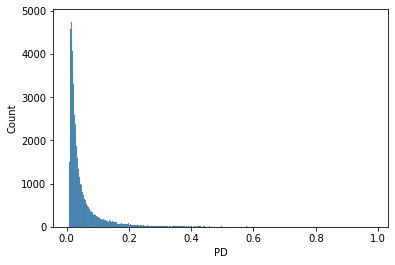

In [66]:
sns.histplot(x="PD", data=train_df);
# вприцнипе судя по ответам модели, она скорее всего переобучилась
# на большем классе - 0.0, 

In [24]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

You should consider upgrading via the 'c:\users\kirill_ionkin\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\kirill_ionkin\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [25]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool, metrics, cv

In [26]:
# для работы с катбустом, заменим все пропуски на -999 к примеру

train_df_catboost = train_df.fillna(-999)
test_df_catboost = test_df.fillna(-999)

In [27]:
# выделяем названия колонок возможных категориальных фичей
cat_features = [column for column in data_df.columns.values if ("category" in column.lower().split("_"))]
cat_features

['Category_Feature_0',
 'Category_Feature_1',
 'Category_Feature_2',
 'Category_Feature_3',
 'Category_Feature_4',
 'Category_Feature_5',
 'Category_Feature_6',
 'Category_Feature_7',
 'Category_Feature_8',
 'Category_Feature_9',
 'Category_Feature_10',
 'Category_Feature_11',
 'Category_Feature_12',
 'Category_Feature_13',
 'Category_Feature_14',
 'Category_Feature_15',
 'Category_Feature_16',
 'Category_Feature_17',
 'Category_Feature_18']

In [28]:
data_df[cat_features].nunique()
# Category_Feature_8 многовато для категорилальной фичи

Category_Feature_0        15
Category_Feature_1         2
Category_Feature_2        55
Category_Feature_3         6
Category_Feature_4        15
Category_Feature_5         7
Category_Feature_6         2
Category_Feature_7         4
Category_Feature_8     24239
Category_Feature_9         2
Category_Feature_10        2
Category_Feature_11        2
Category_Feature_12        2
Category_Feature_13        4
Category_Feature_14       14
Category_Feature_15        6
Category_Feature_16       33
Category_Feature_17        6
Category_Feature_18       12
dtype: int64

In [27]:
# колосальный размах данных ... сомневаюсь, что данный признак будет
# полезен, но всё таки из категориальных данных стоит его убрать
data_df["Category_Feature_8"].max(), data_df["Category_Feature_8"].min()

(27584619.849, 0.0)

<AxesSubplot:xlabel='Category_Feature_8', ylabel='Count'>

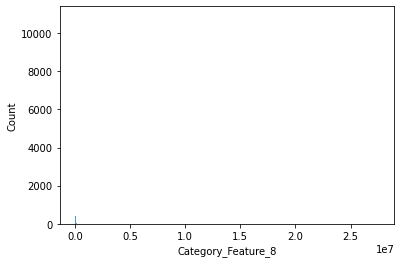

In [97]:
# посмотрим на распределение той самой категорилальной фичи, которая имеет так много уникальных значений
# sns.histplot(x="Category_Feature_8", data=data_df) 

In [29]:
# процент NaN, который среди категориальных фичей
data_df[cat_features].isna().sum() / len(data_df)

Category_Feature_0     0.000266
Category_Feature_1     0.000000
Category_Feature_2     0.000000
Category_Feature_3     0.046104
Category_Feature_4     0.046104
Category_Feature_5     0.000000
Category_Feature_6     0.000000
Category_Feature_7     0.003438
Category_Feature_8     0.003438
Category_Feature_9     0.003438
Category_Feature_10    0.003438
Category_Feature_11    0.003438
Category_Feature_12    0.003438
Category_Feature_13    0.052132
Category_Feature_14    0.052132
Category_Feature_15    0.052132
Category_Feature_16    0.052132
Category_Feature_17    0.178970
Category_Feature_18    0.052132
dtype: float64

In [31]:
cat_features.remove("Category_Feature_8")

In [30]:
train_df_catboost.isna().sum().sum()

0

In [31]:
test_df_catboost.isna().sum().sum()

0

In [32]:
X_train_df_catboost = train_df_catboost.drop(columns=["|PD-flg_90_12_add|"])
y_train_df_catboost = train_df_catboost["|PD-flg_90_12_add|"]

In [33]:
X_test_df_catboost = test_df_catboost

In [ ]:
# сохраним данные датасеты для дальнейшей работы с ними с помощью катбуста
# X_train_df_catboost.to_csv(os.path.join(CATBOOST_DATA_FOLDER, "X_train_df_catboost.csv"), columns=X_train_df_catboost.columns.values, header=True, index=True)
#y_train_df_catboost.to_csv()

#X_test_df_catboost.to_csv()

### Разобьём данные для валидации модели

In [ ]:
# в следующий раз попробуем разбить данные
# с помощью train_test_split стратифицированно

In [34]:
# разобьём данные на train/val
n = len(X_train_df_catboost)
X_train_catboost, X_val_catboost =\
    X_train_df_catboost.iloc[:int(0.8*n)], X_train_df_catboost.iloc[int(0.8*n):]
y_train_catboost, y_val_catboost = \
    y_train_df_catboost.iloc[:int(0.8*n)], y_train_df_catboost.iloc[int(0.8*n):]

In [35]:
X_train_catboost.shape, y_train_catboost.shape,\
X_val_catboost.shape, y_val_catboost.shape

((65293, 1909), (65293,), (16324, 1909), (16324,))

### Первая модель:

catboost, +- стандартные настройки

In [ ]:
# собственно само обучение модели

In [36]:
catboost_model_v1 = CatBoostRegressor( 
    loss_function="MAE",
    random_seed=SEED,
    logging_level="Silent",
    use_best_model=True
)

In [37]:
catboost_model_v1.fit(
    X_train_catboost, y_train_catboost,
    eval_set=(X_val_catboost, y_val_catboost),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [38]:
catboost_model_v1.best_score_

{'learn': {'MAE': 0.05733004023288085},
 'validation': {'MAE': 0.05463405126566879}}

In [40]:
catboost_model_v1.feature_importances_

array([1.07866089e+00, 3.92737343e+00, 4.20704275e+00, ...,
       5.48364430e-02, 2.81239030e-03, 1.21576071e-01])

In [41]:
X_test_catboost_predictions = catboost_model_v1.predict(X_test_df_catboost)

<font color="green" size=5>score на тесте: 0.06003</font>

In [76]:
#create_csv_file(name="catboost_model_v1_submission_1.csv", predictions=X_test_catboost_predictions)

save predictions in: submissions\catboost_model_v1_submission_1.csv


In [ ]:
# Попробуем завизуализировать важность тех или иных признаков

In [42]:
def plot_feature_importance(catboost_model, n_first=100):
    feature_names = catboost_model.feature_names_
    feature_importance = catboost_model.feature_importances_
    
    df_feature_importance = pd.DataFrame({"feature_names": feature_names,
                                          "feature_importance": feature_importance 
                                         })
    df_feature_importance.sort_values(by=["feature_importance"], ascending=False, inplace=True)

    plt.figure(figsize=(15, 10))
    ax = df_feature_importance[:n_first].plot('feature_names', 'feature_importance', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    plt.show()
    
    return df_feature_importance

<Figure size 1080x720 with 0 Axes>

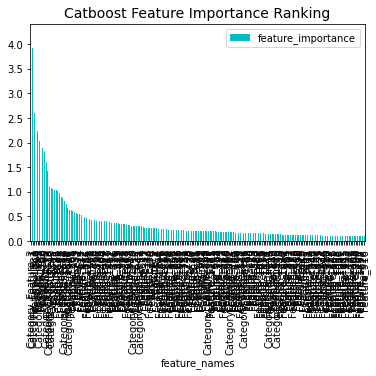

In [43]:
df_feature_importance = plot_feature_importance(catboost_model_v1, n_first=200);

In [44]:
df_feature_importance

,feature_names,feature_importance
2,Category_Feature_2,4.207043
1,Category_Feature_1,3.927373
1902,Feature_1883,2.591145
979,Feature_960,2.397055
814,Feature_795,2.235030
...,...,...
1289,Feature_1270,0.000000
1290,Feature_1271,0.000000
120,Feature_101,0.000000
1294,Feature_1275,0.000000


In [46]:
# а какое кол-во фичей по важности больше нуля
important_features_1 = df_feature_importance[df_feature_importance["feature_importance"] > 0.0]
important_features_1

,feature_names,feature_importance
2,Category_Feature_2,4.207043
1,Category_Feature_1,3.927373
1902,Feature_1883,2.591145
979,Feature_960,2.397055
814,Feature_795,2.235030
...,...,...
1858,Feature_1839,0.000120
257,Feature_238,0.000109
513,Feature_494,0.000105
1791,Feature_1772,0.000072


In [47]:
important_features_1["feature_names"].values

array(['Category_Feature_2', 'Category_Feature_1', 'Feature_1883', ...,
       'Feature_494', 'Feature_1772', 'Feature_566'], dtype=object)

### Вторая модель. Использование train_test_split


In [108]:
X_train_catboost_1, X_val_catboost_1, y_train_catboost_1, y_val_catboost_1 = \
    train_test_split(X_train_df_catboost,
                     y_train_df_catboost,
                     test_size=0.8, # при первом прогоне было 0.8(оставил также на 0.8 для воспроизводимости дальнейних результатов)
                     random_state=SEED,
                     shuffle=True, 
                    )

In [109]:
catboost_model_v2_2 = CatBoostRegressor( 
    loss_function="MAE",
    random_seed=SEED,
    logging_level="Silent",
    use_best_model=True
)

In [52]:
catboost_model_v2_2.fit(
    X_train_catboost_1, y_train_catboost_1,
    eval_set=(X_val_catboost_1, y_val_catboost_1),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
# хм,  чисто визуально .... по сравнению с предыдущим графиком обучения,
# видно, что модель горадно раньше выходит на плато по метрике ... 

# Есть предположение, что данные всё таки зависят от времени,
# поэтому вознкиает идея отсортировать данные для train, 
# взять 20% данных для валидации



<font color="green" size=5> Test score: 0.05992</font>

In [ ]:
# хм .... на val данных качество хуже, чем на прошлых данных, но качество
# на тесте при это выше ...

# Интересно ... с чем это может быть свзяано ...

# Но всё равно мы должны проверить гипотезу о сортировке train данных

In [110]:
X_test_df_catboost

,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,Category_Feature_8,Category_Feature_9,...,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,|PD-flg_90_12_add|,year,month
incident,,,,,,,,,,,,,,,,,,,,,
21000721,14.0,2,54,2.0,0.0,6,1,3.0,26168.7619,0.0,...,0.338162,0.338162,0,0,0,0,20201,-999.0,2020,2
20969929,3.0,1,32,2.0,1.0,3,1,3.0,30000.0000,0.0,...,-999.000000,-999.000000,0,0,1,1,20201,-999.0,2020,2
20970028,4.0,1,41,2.0,1.0,3,0,2.0,42000.0000,0.0,...,0.722639,-999.000000,0,0,0,1,20201,-999.0,2020,2
21001976,15.0,1,29,1.0,0.0,6,1,1.0,23000.0000,0.0,...,-999.000000,-999.000000,0,1,0,0,20201,-999.0,2020,2
21003292,1.0,2,36,2.0,1.0,5,0,3.0,32000.0000,0.0,...,-999.000000,-999.000000,0,0,1,0,20201,-999.0,2020,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20559842,1.0,2,34,2.0,2.0,3,0,2.0,35000.0000,0.0,...,0.187271,-999.000000,0,0,0,1,20201,-999.0,2020,1
20380255,10.0,2,66,2.0,0.0,5,1,3.0,19000.0000,0.0,...,0.391072,0.391072,0,0,0,0,20201,-999.0,2020,1
20348581,4.0,1,32,1.0,0.0,3,0,1.0,0.0000,0.0,...,-999.000000,-999.000000,0,1,1,1,20201,-999.0,2020,1


In [111]:
X_train_df_catboost

,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,Category_Feature_8,Category_Feature_9,...,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887,year,month
incident,,,,,,,,,,,,,,,,,,,,,
14511110,6.0,2,25,2.0,0.0,3,1,2.0,35000.0000,0.0,...,-999.000000,-999.000000,-999.00000,0,0,0,1,20184,2018,10
15018800,1.0,2,49,4.0,0.0,3,1,2.0,50000.0000,0.0,...,0.547065,0.287680,0.28768,0,1,1,1,20184,2018,12
14499737,6.0,2,24,1.0,0.0,3,0,1.0,20000.0000,0.0,...,0.242687,-999.000000,-999.00000,0,1,0,1,20184,2018,10
14953427,4.0,2,26,1.0,0.0,3,1,2.0,30000.0000,0.0,...,-999.000000,-999.000000,-999.00000,0,1,1,1,20184,2018,12
14744453,6.0,2,30,4.0,2.0,3,1,3.0,50000.0000,0.0,...,-999.000000,-999.000000,-999.00000,0,1,0,1,20184,2018,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20998757,1.0,2,56,2.0,0.0,3,0,4.0,66000.0000,0.0,...,0.126789,0.035624,-999.00000,0,0,1,1,20201,2020,2
20999207,4.0,2,29,2.0,1.0,5,0,2.0,0.0000,0.0,...,-999.000000,-999.000000,-999.00000,0,0,1,0,20201,2020,2
20999293,1.0,1,54,2.0,1.0,6,0,3.0,128615.0000,0.0,...,0.212479,-999.000000,-999.00000,0,0,1,0,20201,2020,2


In [53]:
X_test_catboost_v2_predictions = catboost_model_v2.predict(X_test_df_catboost)

In [133]:
#create_csv_file(name="catboost_model_v2_submission_1.csv", predictions=X_test_catboost_v2_predictions)

save predictions in: submissions\catboost_model_v2_submission_1.csv


<Figure size 1080x720 with 0 Axes>

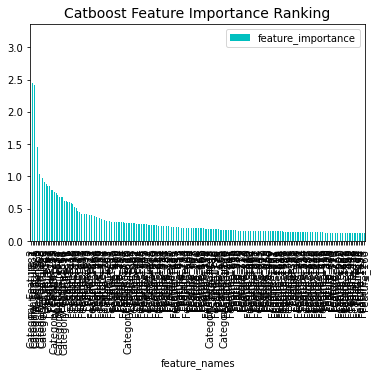

In [54]:
# посмотрим на распределение важности признаков, и выделим наиболее
# важные

df_feature_importance_2 = plot_feature_importance(catboost_model_v2, n_first=200);

In [55]:
df_feature_importance_2

,feature_names,feature_importance
2,Category_Feature_2,3.206088
1902,Feature_1883,2.451236
1,Category_Feature_1,2.414788
5,Category_Feature_5,1.669712
979,Feature_960,1.459354
...,...,...
1228,Feature_1209,0.000000
156,Feature_137,0.000000
1232,Feature_1213,0.000000
1235,Feature_1216,0.000000


In [56]:
# а какое кол-во фичей по важности больше нуля
important_features_2 = df_feature_importance_2[df_feature_importance_2["feature_importance"] > 0.0]
important_features_2

,feature_names,feature_importance
2,Category_Feature_2,3.206088
1902,Feature_1883,2.451236
1,Category_Feature_1,2.414788
5,Category_Feature_5,1.669712
979,Feature_960,1.459354
...,...,...
1547,Feature_1528,0.000052
1801,Feature_1782,0.000048
1796,Feature_1777,0.000044
465,Feature_446,0.000036


In [57]:
important_features_2["feature_names"].values

array(['Category_Feature_2', 'Feature_1883', 'Category_Feature_1', ...,
       'Feature_1777', 'Feature_446', 'Feature_1717'], dtype=object)

### Третья модель, учтём лишь наиболее важные фичи, коотрые мы получили с прошлых шагов

In [82]:
important_columns_union_1_2 = list(set(important_features_1["feature_names"].values).union(important_features_2["feature_names"].values))
important_columns_union_1_2

['Feature_1708',
 'Feature_1836',
 'Feature_1807',
 'Feature_597',
 'Feature_1521',
 'Feature_1614',
 'Feature_260',
 'Feature_758',
 'Feature_1484',
 'Feature_34',
 'Feature_609',
 'Feature_1461',
 'Feature_1104',
 'Feature_809',
 'Feature_700',
 'Feature_1041',
 'Category_Feature_14',
 'Feature_477',
 'Feature_408',
 'Feature_944',
 'Feature_753',
 'Feature_696',
 'Feature_1162',
 'Feature_457',
 'Feature_1537',
 'Feature_1838',
 'Feature_503',
 'Feature_759',
 'Feature_1480',
 'Feature_1212',
 'Feature_1014',
 'Feature_226',
 'Feature_1068',
 'Feature_1421',
 'Feature_873',
 'Feature_1118',
 'Feature_1210',
 'Feature_1064',
 'Feature_638',
 'Feature_930',
 'Feature_259',
 'Feature_246',
 'Feature_1246',
 'Feature_308',
 'Feature_1840',
 'Feature_63',
 'Feature_1029',
 'Feature_1442',
 'Feature_632',
 'Feature_1130',
 'Feature_1864',
 'Feature_671',
 'Feature_718',
 'Feature_941',
 'Feature_1318',
 'Feature_1448',
 'Feature_1157',
 'Feature_204',
 'Feature_171',
 'Feature_637',
 'Fea

In [88]:
X_train_df_catboost_union_1_2 = X_train_df_catboost[important_columns_union_1_2]
y_train_df_catboost_union_1_2 = y_train_df_catboost
X_test_df_catboost_union_1_2 = X_test_df_catboost[important_columns_union_1_2]

X_train_df_catboost_union_1_2.shape, y_train_df_catboost_union_1_2.shape, \
X_test_df_catboost_union_1_2.shape

((81617, 1493), (81617,), (1000, 1493))

In [89]:
# обучим на данных фичах модель также 2мя способами 
# 1) используя полседнюю выборку из train для валидации
# 2) train_test_split

In [90]:
# 1) Разделим данный для train/val данные

n = len(X_train_df_catboost_union_1_2)
X_train_catboost, X_val_catboost =\
    X_train_df_catboost_union_1_2.iloc[:int(0.8*n)], X_train_df_catboost_union_1_2.iloc[int(0.8*n):]
y_train_catboost, y_val_catboost = \
    y_train_df_catboost_union_1_2.iloc[:int(0.8*n)], y_train_df_catboost_union_1_2.iloc[int(0.8*n):]

In [91]:
X_train_catboost.shape, y_train_catboost.shape,\
X_val_catboost.shape, y_val_catboost.shape

((65293, 1493), (65293,), (16324, 1493), (16324,))

In [93]:
catboost_model_v3 = CatBoostRegressor( 
    loss_function="MAE",
    random_seed=SEED,
    logging_level="Silent",
    use_best_model=True
)

In [94]:
catboost_model_v3.fit(
    X_train_catboost, y_train_catboost,
    eval_set=(X_val_catboost, y_val_catboost),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
# Если судить только по валидационной выборке, то 
# модель немного лучше себя показала при уменьшении кол-ва колонок,
# Оставили, хоть сколько угодно выжные колонки
# по мнению катбуста на прошлых итерациях обучения

In [95]:
X_test_catboost_v3_predictions = catboost_model_v3.predict(X_test_df_catboost_union_1_2)

<font color="green" size=5>Test score: 0.05996</font>

In [ ]:
# По сравнению, с аналогичным разбиением данных, но без чистки
# данных по столбцам, качество модели на teste слегка лучше, 
# но по сравнению с train_test_split качество модели оказалось чуть хуже

In [96]:
create_csv_file(name="catboost_model_v3_submission_1.csv", predictions=X_test_catboost_v3_predictions)

save predictions in: submissions\catboost_model_v3_submission_1.csv


<Figure size 1080x720 with 0 Axes>

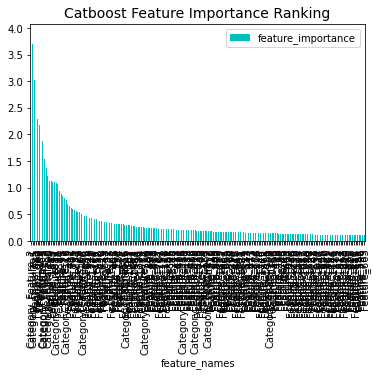

In [97]:
df_feature_importance_3 = plot_feature_importance(catboost_model_v3, n_first=200);

In [98]:
df_feature_importance_3

,feature_names,feature_importance
266,Category_Feature_2,3.887654
832,Category_Feature_1,3.702211
1320,Feature_795,3.020727
276,Feature_1883,2.439703
224,Feature_960,2.290089
...,...,...
789,Feature_147,0.000000
790,Feature_865,0.000000
792,Feature_113,0.000000
797,Feature_938,0.000000


In [99]:
# наиболее важные принаки по мнению данного катбуста
important_features_3 = df_feature_importance_3[df_feature_importance_3["feature_importance"] > 0.0]
important_features_3

,feature_names,feature_importance
266,Category_Feature_2,3.887654
832,Category_Feature_1,3.702211
1320,Feature_795,3.020727
276,Feature_1883,2.439703
224,Feature_960,2.290089
...,...,...
481,Feature_93,0.000192
214,Feature_1309,0.000171
888,Feature_94,0.000167
1215,Feature_1786,0.000030


### Обучение 4ой модели

In [100]:
# Теперь разобьём данные с помощью train_test_splt
X_train_catboost_4, X_val_catboost_4, y_train_catboost_4, y_val_catboost_4 = \
    train_test_split(X_train_df_catboost_union_1_2,
                     y_train_df_catboost_union_1_2,
                     test_size=0.2,
                     random_state=SEED,
                     shuffle=True, 
                    )

In [101]:
X_train_catboost_4.shape, y_train_catboost_4.shape,\
X_val_catboost_4.shape, y_val_catboost_4.shape

((65293, 1493), (65293,), (16324, 1493), (16324,))

In [103]:
catboost_model_v4 = CatBoostRegressor( 
    loss_function="MAE",
    random_seed=SEED,
    logging_level="Silent",
    use_best_model=True
)

In [104]:
catboost_model_v4.fit(
    X_train_catboost_4, y_train_catboost_4,
    eval_set=(X_val_catboost_4, y_val_catboost_4),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [105]:
X_test_catboost_v4_predictions = catboost_model_v4.predict(X_test_df_catboost_union_1_2)

<font color="green" size=5> Train score: 0.05939!!!! Пока лучшее решение</font>

In [106]:
create_csv_file(name="catboost_model_v4_submission_1.csv", predictions=X_test_catboost_v4_predictions)

save predictions in: submissions\catboost_model_v4_submission_1.csv


<Figure size 1080x720 with 0 Axes>

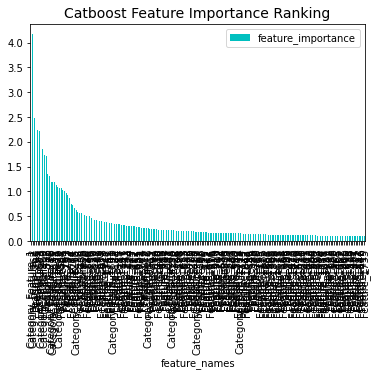

In [138]:
df_feature_importance_4 = plot_feature_importance(catboost_model_v4, n_first=200);

In [140]:
df_feature_importance_4

,feature_names,feature_importance
832,Category_Feature_1,4.175115
266,Category_Feature_2,4.169374
943,Feature_962,2.480471
1320,Feature_795,2.254491
506,Feature_69,2.242979
...,...,...
1020,Feature_1018,0.000000
337,Feature_1539,0.000000
1018,Feature_523,0.000000
1015,Feature_351,0.000000


In [147]:
important_features_4 = df_feature_importance_4[df_feature_importance_4["feature_importance"] > 0.0]
important_features_4

,feature_names,feature_importance
832,Category_Feature_1,4.175115
266,Category_Feature_2,4.169374
943,Feature_962,2.480471
1320,Feature_795,2.254491
506,Feature_69,2.242979
...,...,...
522,Feature_1160,0.000241
902,Feature_1556,0.000220
1311,Feature_757,0.000214
1445,Feature_706,0.000111


### Те фильтры, которые у нас пока имеются по колонкам

In [133]:
important_features_1.shape, important_features_2.shape, len(important_columns_union_1_2), important_features_3.shape

((1117, 2), (1313, 2), 1493, (1056, 2))

In [177]:
set_1 = set(important_features_1["feature_names"])
set_2 = set(important_features_2["feature_names"])
set_union_1_2 = important_columns_union_1_2
set_3 = set(important_features_3["feature_names"])
set_4 = set(important_features_4["feature_names"])

len(set_1), len(set_2), len(set_union_1_2), len(set_4), len(set_3)

(1117, 1313, 1493, 1065, 1056)

In [176]:
len(set_1.intersection(set_2)) # пробовал обьединение уже ранее

937

In [165]:
important_features_1_2_3_4_intersection = set_1.intersection(set_4).intersection(set_2).intersection(set_3)
len(important_features_1_2_3_4_intersection)

664

In [179]:
len(set_4.intersection(set_3))

849

### Попробуем обучить не только бустинг, но и  другой алгоритм - к примеру случайные леса

In [189]:
from sklearn.ensemble import RandomForestRegressor

In [188]:
# попробуем для начала important_features_1_2_3_4_intersection

In [185]:
y_train_rf = train_df["|PD-flg_90_12_add|"]
y_train_rf.shape

(81617,)

In [186]:
train_df_rf = train_df[important_features_1_2_3_4_intersection]
train_df_rf.shape

(81617, 664)

In [187]:
test_df_rf = test_df[important_features_1_2_3_4_intersection]
test_df_rf.shape

(1000, 664)

In [192]:
train_df_rf = train_df_rf.fillna(-999)
test_df_rf = test_df_rf.fillna(-999)

In [ ]:
# рзделим данные с помощью train_test_split

In [193]:
X_train_rf_1, X_val_rf_1, y_train_rf_1, y_val_rf_1 = \
    train_test_split(train_df_rf,
                     y_train_rf,
                     test_size=0.2,
                     random_state=SEED,
                     shuffle=True, 
                    )

In [196]:
#rf_reg_v1 = RandomForestRegressor(n_estimator=10)
#rf_reg_v1.fit(X_train_rf_1, y_train_rf_1)

In [ ]:
X_train

In [199]:
train_df[important_features_1_2_3_4_intersection].isna().sum() / len(train_df)

Feature_578     0.673009
Feature_528     0.562616
Feature_664     0.454672
Feature_97      0.000000
Feature_1836    0.578054
                  ...   
Feature_239     0.671931
Feature_1878    0.764902
Feature_1744    0.000000
Feature_1877    0.691180
Feature_1068    0.192975
Length: 664, dtype: float64

In [212]:
train_df.index

Int64Index([14511110, 15018800, 14499737, 14953427, 14744453, 14759491,
            14903694, 15089288, 14953081, 14659768,
            ...
            20997407, 20997630, 20998230, 20951964, 20998309, 20998757,
            20999207, 20999293, 20999311, 20952899],
           dtype='int64', name='incident', length=81617)

In [214]:
bool_mask = (train_df[important_features_1_2_3_4_intersection].isna().sum() / len(train_df) <= 0.5).values
bool_mask

array([False, False,  True,  True, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
        True,  True,  True,  True, False, False,  True, False,  True,
       False,  True, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False, False,  True,  True, False, False, False,  True,
        True, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False,  True, False, False,  True, False,  True,
        True, False, False,  True, False, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True, False, False, False, False,  True,  True,  True,
       False,  True,

In [221]:
interest_features = train_df[important_features_1_2_3_4_intersection].columns[bool_mask]
interest_features

Index(['Feature_664', 'Feature_97', 'Feature_260', 'Feature_1774', 'month',
       'Category_Feature_14', 'Feature_753', 'Category_Feature_17',
       'Feature_666', 'Feature_1838',
       ...
       'Feature_590', 'Feature_929', 'Feature_544', 'Feature_653',
       'Feature_591', 'Feature_1753', 'Feature_425', 'Feature_1887',
       'Feature_1744', 'Feature_1068'],
      dtype='object', length=281)

In [225]:
train_df_rf = train_df[interest_features]
y_train_df_rf = train_df["|PD-flg_90_12_add|"]
test_df_rf = test_df[interest_features]

In [226]:
train_df_rf.shape, y_train_df_rf.shape, test_df_rf.shape

((81617, 281), (81617,), (1000, 281))

In [227]:
train_df_rf = train_df_rf.fillna(-999)
test_df_rf = test_df_rf.fillna(-999)

In [228]:
X_train_rf_1, X_val_rf_1, y_train_rf_1, y_val_rf_1 = \
    train_test_split(train_df_rf,
                     y_train_df_rf,
                     test_size=0.2,
                     random_state=SEED,
                     shuffle=True, 
                    )

In [230]:
rf_reg_v1 = RandomForestRegressor()
rf_reg_v1.fit(X_train_rf_1, y_train_rf_1)

KeyboardInterrupt: 